# Import 

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import qutip as qt
from copy import deepcopy
import scipy as sp


import experiments as meas
from experiments.MM_dual_rail_base import MM_dual_rail_base
from fitting.fit_display_classes import GeneralFitting
from fitting.wigner import WignerAnalysis

from slab import AttrDict
from experiments import MultimodeStation, CharacterizationRunner, SweepRunner

from job_server import JobClient
from job_server.database import get_database
from job_server.config_versioning import ConfigVersionManager

# Initialize database and config manager
db = get_database()
config_dir = 'D:/python/multimode_expts/configs'
config_manager = ConfigVersionManager(config_dir)

# Initialize job client (handle submitting and waiting for jobs)
client = JobClient()

# Check server health
health = client.health_check()
print(f"Server status: {health['status']}")
print(f"Pending jobs: {health['pending_jobs']}")

user = "seb"
print("Welcome", user)


station = MultimodeStation(
    user=user,
    experiment_name = "250119_qec",
)

USE_QUEUE = True
mm_base_calib = MM_dual_rail_base(station.hardware_cfg, station.soc)

# Calibrate single shot 

In [ ]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
singleshot_defaults = AttrDict(dict(    
    reps=5000,
    relax_delay=500,
    check_f=False,
    active_reset=False,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    cavity_freq=4984.373226159381,
    cavity_gain=400,
    cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    qubits=[0],
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values



def singleshot_postproc(station, expt):
    expt.analyze(plot=False, station=station, subdir=station.autocalib_path)
    fids = expt.data['fids']
    confusion_matrix = expt.data['confusion_matrix']
    thresholds_new = expt.data['thresholds']
    angle = expt.data['angle']
    print(fids)

    hardware_cfg = station.hardware_cfg
    hardware_cfg.device.readout.phase = [hardware_cfg.device.readout.phase[0] + angle]
    hardware_cfg.device.readout.threshold = thresholds_new
    hardware_cfg.device.readout.threshold_list = [thresholds_new]
    hardware_cfg.device.readout.Ie = [np.median(expt.data['Ie_rot'])]
    hardware_cfg.device.readout.Ig = [np.median(expt.data['Ig_rot'])]
    if expt.cfg.expt.active_reset:
        hardware_cfg.device.readout.confusion_matrix_with_active_reset = confusion_matrix
    else:
        hardware_cfg.device.readout.confusion_matrix_without_reset = confusion_matrix
    print('Updated readout!')

    expt.display(station)

In [ ]:
single_shot_runner = CharacterizationRunner(
    station = station,
    ExptClass = meas.HistogramExperiment,
    default_expt_cfg = singleshot_defaults,
    postprocessor = singleshot_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)

single_shot = single_shot_runner.execute(
        go_kwargs=dict(analyze=False, display=False),
        check_f=False,
        active_reset=False, # on recalibration of readout, turn off active reset because it will be wrong for selecting when to apply the qubit pulse
        relax_delay=2000,
        gate_based=False,
    )

# Calibrate the beam splitter 

In [ ]:
# Helper function (kept from original)
def get_storage_mode_parameters(ds_storage, config_thisrun, man_mode_no, stor_mode_no):
    """Get pulse parameters for a given storage mode."""
    stor_name = 'M' + str(man_mode_no) + '-S' + str(stor_mode_no)
    freq = ds_storage.get_freq(stor_name)
    gain = ds_storage.get_gain(stor_name)
    pi_len = ds_storage.get_pi(stor_name)
    h_pi_len = ds_storage.get_h_pi(stor_name)
    flux_low_ch = config_thisrun.hw.soc.dacs.flux_low.ch
    flux_high_ch = config_thisrun.hw.soc.dacs.flux_high.ch
    ch = flux_low_ch if freq < 1000 else flux_high_ch

    mm_base_dummy = MM_dual_rail_base(config_thisrun, soccfg=station.soc)
    prepulse = mm_base_dummy.prep_man_photon(man_mode_no)
    postpulse = mm_base_dummy.prep_man_photon(man_mode_no)
    # prepulse = mm_base_dummy.get_prepulse_creator(prepulse).pulse.tolist()
    # postpulse = mm_base_dummy.get_prepulse_creator(prepulse[-1:-3:-1]).pulse.tolist()

    return freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse


# Configuration defaults for error amplification
error_amp_stor_defaults = AttrDict(dict(
    reps=50,
    rounds=1,
    qubit=0,
    qubits=[0],
    n_start=0,
    n_step=3,
    n_pulses=15,
    expts=50,
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    relax_delay=2500,
    qubit_state_start='g',
))


def error_amp_stor_preproc(station, default_expt_cfg, man_mode_no=1, stor_mode_no=1, 
                           parameter_to_test='gain', span=None, start=None, **kwargs):
    """Preprocessor for error amplification storage."""
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)
    
    stor_name = f'M{man_mode_no}-S{stor_mode_no}'
    
    # Get current values
    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(
        station.ds_storage, station.hardware_cfg, man_mode_no, stor_mode_no
    )    
    # Set pulse type for storage mode
    expt_cfg.pulse_type = ['storage', stor_name, 'pi', 0]
    expt_cfg.parameter_to_test = parameter_to_test
    
    # Set sweep range based on parameter
    if parameter_to_test == 'gain':
        if span is None:
            span = int(gain * 0.3)  # 30% of current gain
        if start is None:
            expt_cfg.start = int(gain - span / 2)

        expt_cfg.step = int(span / (expt_cfg.expts - 1))
    elif parameter_to_test == 'frequency':
        if span is None:
            span = 0.15  # MHz
        if start is None:
            expt_cfg.start = freq - span / 2
        expt_cfg.step = span / (expt_cfg.expts - 1)
    
    print(f'Error amp ({parameter_to_test}) for {stor_name}: center={freq if parameter_to_test=="frequency" else gain}, span={span}')
    
    return expt_cfg


In [ ]:
expts_to_run = {
                #storage
                'stor_modes': [1], # [1,2, .., 7] if also want to run  all modes 
                }
man_mode_no = 1

In [ ]:
length_vectors = {}
gain_vectors = {}
freq_vectors = {}
num_pts = 20
qubit_states = ['g', 'e']

for stor_mode_no in expts_to_run.get('stor_modes', [1]):
    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(
        station.ds_storage, station.hardware_cfg, man_mode_no, stor_mode_no
    )

    len_min = (pi_len * 0.3)
    len_max = (pi_len * 1.2)


    gain_min = gain * pi_len / len_max
    gain_max = gain * pi_len / len_min
    print(f"Gain range for storage mode {stor_mode_no}: {gain_min} to {gain_max}")

    
    # Initialize nested dicts for this mode
    length_vectors[stor_mode_no] = {}
    gain_vectors[stor_mode_no] = {}
    freq_vectors[stor_mode_no] = {}
    
    for qubit_state in qubit_states:
        gain_vectors[stor_mode_no][qubit_state] = np.linspace(gain_min, gain_max, num=num_pts)
        length_vectors[stor_mode_no][qubit_state] = pi_len * gain / gain_vectors[stor_mode_no][qubit_state]
        freq_vectors[stor_mode_no][qubit_state] = np.linspace(freq, freq, num=num_pts)
        if qubit_state == 'e':
            freq_vectors[stor_mode_no][qubit_state] += station.hardware_cfg.device.manipulate.chi_ge[man_mode_no - 1]
    
    print(f"Storage mode {stor_mode_no}:")
    print("Length vectors:", length_vectors[stor_mode_no])
    print("Gain vectors:", gain_vectors[stor_mode_no])
    print("Frequency vectors:", freq_vectors[stor_mode_no])

In [ ]:
qubit_start = 'e'
reps = 100
n_steps = 3
n_pulses = 10
analyze = False
display = False 

In [ ]:
# Error Amplification Storage - New Pattern with CharacterizationRunner

# Example execution - gain optimization followed by frequency optimization
for stor_mode_no in expts_to_run.get('stor_modes', [1]):
    stor_name = f'M1-S{stor_mode_no}'

    original_freq, original_gain, original_pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(
        station.ds_storage, station.hardware_cfg, man_mode_no, stor_mode_no
    )

    # set the pi_length, gain and frequency to be tested
    for idx, pi_len_test in enumerate(length_vectors[stor_mode_no][qubit_start]):
        station.ds_storage.update_pi(stor_name, pi_len_test)
        _idx = idx if idx==0 else idx-1
        station.ds_storage.update_gain(stor_name, gain_vectors[stor_mode_no][qubit_start][idx])  
        station.ds_storage.update_freq(stor_name, freq_vectors[stor_mode_no][qubit_start][_idx]) 
        print(station.ds_storage.get_pi(stor_name)) 

        print(f'Running error amp (frequency) for {stor_name}')
        print(f"Testing pi length: {pi_len_test} us, gain: {gain_vectors[stor_mode_no][qubit_start][idx]}, frequency: {freq_vectors[stor_mode_no][qubit_start][_idx]} MHz")
        # Round 1: Frequency optimization

        error_amp_stor_runner = CharacterizationRunner(
            station=station,
            ExptClass=meas.single_qubit.error_amplification.ErrorAmplificationExperiment,
            default_expt_cfg=error_amp_stor_defaults,
            preprocessor=error_amp_stor_preproc,
            # postprocessor=error_amp_stor_postproc,
            job_client=client,
            use_queue=USE_QUEUE,
        )
        error_amp_freq = error_amp_stor_runner.execute(
            man_mode_no=man_mode_no,
            stor_mode_no=stor_mode_no,
            parameter_to_test='frequency',
            span=0.2,
            n_step=n_steps,
            n_pulses=n_pulses,
            analyze=analyze,
            display=display,
            reps=reps,
            qubit_state_start=qubit_start,
        )

        # update frequency based on optimization

        error_amp_freq.analyze(state_fin='e')
        error_amp_freq.display()
        optimal_value_freq = error_amp_freq.data['fit_avgi'][2]
        freq_vectors[stor_mode_no][qubit_start][idx] = optimal_value_freq
        station.ds_storage.update_freq(stor_name, optimal_value_freq)
        print(f'Updated frequency for {stor_name}: {optimal_value_freq:.4f} MHz')

        # Round 2: Gain optimization
        print(f'Running error amp (gain) for {stor_name}')
        error_amp_stor_runner = CharacterizationRunner(
            station=station,
            ExptClass=meas.single_qubit.error_amplification.ErrorAmplificationExperiment,
            default_expt_cfg=error_amp_stor_defaults,
            preprocessor=error_amp_stor_preproc,
            # postprocessor=error_amp_stor_postproc,
            job_client=client,
            use_queue=USE_QUEUE,
        )
        error_amp_gain = error_amp_stor_runner.execute(
            man_mode_no=man_mode_no,
            stor_mode_no=stor_mode_no,
            parameter_to_test='gain',
            span=int(gain_vectors[stor_mode_no][qubit_start][idx] * 0.35),
            n_step=n_steps,
            n_pulses=n_pulses,
            analyze=analyze,
            display=display,
            reps=reps,
            qubit_state_start=qubit_start,
        )

        # update gain based on optimization
        error_amp_gain.analyze(state_fin='e')
        error_amp_gain.display()
        optimal_value_gain = error_amp_gain.data['fit_avgi'][2]
        gain_vectors[stor_mode_no][qubit_start][idx] = optimal_value_gain
        station.ds_storage.update_gain(stor_name, int(optimal_value_gain))
        print(f'Updated gain for {stor_name}: {int(optimal_value_gain)}')


        # Final Round: Frequency optimization
        print(f'Running final error amp (frequency) for {stor_name}')

        error_amp_stor_runner = CharacterizationRunner(
            station=station,
            ExptClass=meas.single_qubit.error_amplification.ErrorAmplificationExperiment,
            default_expt_cfg=error_amp_stor_defaults,
            preprocessor=error_amp_stor_preproc,
            # postprocessor=error_amp_stor_postproc,
            job_client=client,
            use_queue=USE_QUEUE,
        )
        error_amp_freq_final = error_amp_stor_runner.execute(
            man_mode_no=man_mode_no,
            stor_mode_no=stor_mode_no,
            parameter_to_test='frequency',
            span=0.1,
            n_step=n_steps,
            n_pulses=n_pulses,
            analyze=analyze,
            display=display,
            reps=reps,
            qubit_state_start=qubit_start,
        )

        # update frequency based on optimization
        error_amp_freq_final.analyze(state_fin='e')
        error_amp_freq_final.display()
        optimal_value_freq_final = error_amp_freq_final.data['fit_avgi'][2]
        freq_vectors[stor_mode_no][qubit_start][idx] = optimal_value_freq_final
        station.ds_storage.update_freq(stor_name, optimal_value_freq_final)
        print(f'Updated frequency for {stor_name}: {optimal_value_freq_final:.4f} MHz')
        

    
    # restore original parameters after length sweep
    station.ds_storage.update_pi(stor_name, original_pi_len)
    station.ds_storage.update_gain(stor_name, original_gain)
    station.ds_storage.update_freq(stor_name, original_freq)
        



In [ ]:
# from the pulse length we compute the beam-splitter rate and plot is versus gain, same for frequency 

degree_rate = 2
degree_freq = 10


beam_splitter_rates = {}
for stor_mode_no in expts_to_run.get('stor_modes', [1]):
    beam_splitter_rates[stor_mode_no] = {}
    for qubit_state in qubit_states:
        beam_splitter_rates[stor_mode_no][qubit_state] = 0.25 / (length_vectors[stor_mode_no][qubit_state])

for stor_mode_no in expts_to_run.get('stor_modes', [1]):

    bs_coeffs_g = np.polyfit(gain_vectors[stor_mode_no]['g'], beam_splitter_rates[stor_mode_no]['g'], deg=degree_rate)
    bs_coeffs_e = np.polyfit(gain_vectors[stor_mode_no]['e'], beam_splitter_rates[stor_mode_no]['e'], deg=degree_rate)
    freq_coeffs_g = np.polyfit(gain_vectors[stor_mode_no]['g'], freq_vectors[stor_mode_no]['g'], deg=degree_freq)
    freq_coeffs_e = np.polyfit(gain_vectors[stor_mode_no]['e'], freq_vectors[stor_mode_no]['e'], deg=degree_freq)

    # add the fitted curves
    gain_fit_range = np.linspace(min(gain_vectors[stor_mode_no]['g']), max(gain_vectors[stor_mode_no]['g']), 100)
    bs_fit_g = np.polyval(bs_coeffs_g, gain_fit_range)
    bs_fit_e = np.polyval(bs_coeffs_e, gain_fit_range)

    freq_fit_g = np.polyval(freq_coeffs_g, gain_fit_range)
    freq_fit_e = np.polyval(freq_coeffs_e, gain_fit_range)


    fig1, ax1 = plt.subplots(1,2, figsize=(12,5))
    ax1[0].plot(gain_vectors[stor_mode_no]['g'],beam_splitter_rates[stor_mode_no]['g'],  marker='o', label=f'Storage Mode {stor_mode_no}')
    ax1[1].plot(gain_vectors[stor_mode_no]['g'], freq_vectors[stor_mode_no]['g'], marker='o', label=f'Storage Mode {stor_mode_no}')
    ax1[0].plot(gain_fit_range, bs_fit_g, 'r--', label='Fit (g)')
    ax1[1].plot(gain_fit_range, freq_fit_g, 'r--', label='Fit (g)')


    ax1[0].set_xlabel('Gain')
    ax1[0].set_ylabel('Beam Splitter Rate (MHz)')
    ax1[0].set_title('Beam Splitter Rate vs Gain')
    ax1[0].legend()


    fig2, ax2 = plt.subplots(1,2, figsize=(12,5))

    ax2[0].plot(gain_vectors[stor_mode_no]['e'],beam_splitter_rates[stor_mode_no]['e'],  marker='o')
    ax2[1].plot(gain_vectors[stor_mode_no]['e'], freq_vectors[stor_mode_no]['e'], marker='o')
    ax2[0].plot(gain_fit_range, bs_fit_e, 'r--', label='Fit (g)')
    ax2[1].plot(gain_fit_range, freq_fit_e, 'b--', label='Fit (e)')


    ax2[0].set_xlabel('Gain')
    ax2[0].set_ylabel('Beam Splitter Rate (MHz)')
    ax2[0].set_title('Beam Splitter Rate vs Gain')
    ax2[0].legend()

In [ ]:
# Store coefficients and valid gain range
gains_g = gain_vectors[1]['g']
station.ds_storage.update_bs_rate_coeffs('M1-S1', bs_coeffs_g, qubit_state='g')
station.ds_storage.update_freq_coeffs('M1-S1', freq_coeffs_g, qubit_state='g')
station.ds_storage.update_gain_range('M1-S1', gains_g.min(), gains_g.max(), qubit_state='g')

gains_g = gain_vectors[1]['e']
station.ds_storage.update_bs_rate_coeffs('M1-S1', bs_coeffs_e, qubit_state='e')
station.ds_storage.update_freq_coeffs('M1-S1', freq_coeffs_e, qubit_state='e')
station.ds_storage.update_gain_range('M1-S1', gains_g.min(), gains_g.max(), qubit_state='e')




In [ ]:
station.snapshot_man1_storage_swap(update_main=True)

In [ ]:
gain = station.ds_storage.get_freq_at_bs_rate('M1-S1', bs_rate=0.2, qubit_state='g')
print(f"Gain for BS rate 0.2 MHz (g): {gain}")

# Calibrate the flat top pi pulse length 

In [ ]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
amprabi_defaults = AttrDict(dict(
    start=0,
    step=60,
    expts=151,
    reps=200,
    rounds=1,
    sigma_test=0.1,
    qubit=0,
    pulse_type='flat_top',
    drag_beta=0.0,
    pulse_ge_init=False,
    pulse_ge_after=False,
    checkZZ=False,
    checkEF=False,
    qubits=[0],
    flat_length=0,
    normalize=False,
    single_shot=False,
    singleshot_reps=10000,
    span=50,
    user_defined_freq=[False, 3568.203829046816],
    prepulse=False,
    postpulse=False, 
    if_ef=False,  # If true, will check ef frequency and update it
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values

def amprabi_preproc(station, default_expt_cfg, **kwargs):
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)

    # Copied over but what's all this below????
    # Which ones are actually used? 
    # Can we straighten out all the nested boolean logic???
    pulse_ge = station.hardware_cfg.device.qubit.pulses.pi_ge
    if expt_cfg.sigma_test is None:
        expt_cfg.sigma_test = pulse_ge.sigma[0]
    if expt_cfg.step is None:
        expt_cfg.step = int(pulse_ge.gain[0] / (expt_cfg.expts - 1))
    
    expt_cfg.checkEF = False
    expt_cfg.pulse_ge_init = False
    expt_cfg.pulse_ge_after = False
    if expt_cfg.if_ef:
        expt_cfg.checkEF = True
        expt_cfg.pulse_ge_init = True
        expt_cfg.pulse_ge_after = True
    
    return expt_cfg

def amprabi_postproc(station, expt):
    station.hardware_cfg.device.qubit.pulses.pi_ge.gain = [expt.data['pi_gain_avgi']]
    station.hardware_cfg.device.qubit.pulses.hpi_ge.gain = [expt.data['hpi_gain_avgi']]
    print('Updated qubit ge pi and hpi gaussian gain!')

In [ ]:
# Execute
# =================================
amprabi_runner = CharacterizationRunner(
    station = station,
    ExptClass = meas.AmplitudeRabiExperiment,
    default_expt_cfg = amprabi_defaults,
    # preprocessor = amprabi_preproc,
    # postprocessor = amprabi_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)

In [ ]:
N_qubit = 1 # number of 2pi rotation on the qubit 
N_bs = 3 # number of 2pi rotation on the beam splitter
chi_ge = station.hardware_cfg.device.manipulate.chi_ge[man_mode_no - 1]
g_bs_guess = np.abs(chi_ge) * ((N_bs**2 - N_qubit**2) / (4*N_qubit**2 - 1))**1/2
Tp = 1 / np.abs(chi_ge) * (4*N_qubit**2 - 1)** 1/2 * (1 - 1/(4*N_bs**2))**(-1/2)

print(f"Initial guess for beam-splitter rate: {g_bs_guess:.4f} MHz")
print(f"Initial guess for beam-splitter pulse length: {Tp:.4f} us")

gain_qb_pi_pulse = station.hardware_cfg.device.qubit.pulses.pi_ge.gain[0]
sigma_qb_pi_pulse = station.hardware_cfg.device.qubit.pulses.pi_ge.sigma[0]
pi_pulse_type = station.hardware_cfg.device.qubit.pulses.pi_ge.type[0]
assert pi_pulse_type == 'gauss', "Only gaussian pi pulse is supported for now"
n=4 # assume the pulse is 4 sigma long
theta_to_gain = np.pi/2/gain_qb_pi_pulse
drive_to_gain_qb = sigma_qb_pi_pulse * np.sqrt(np.pi)/theta_to_gain * sp.special.erf(n/2)
length_to_gain = drive_to_gain_qb / 4

# sigma_flat_top = 0.03
# nb_point = 1
# gain_start = 5 
# gain_end  = 10 
# gain_vec = np.arange(gain_start, gain_end, (gain_end - gain_start)/nb_point)
# length_vec = length_to_gain / gain_vec



length_vec = [Tp]
# print("Gain vec:", gain_vec)
print("Length vec:", length_vec)

In [ ]:
for gain, length in zip(gain_vec, length_vec):
    print(f"Gain: {gain}, Length: {length}")
    amprabi = amprabi_runner.execute(
        go_kwargs=dict(analyze=True, display=True),
        gain=gain,
        flat_length=length,
        sigma_test=sigma_flat_top,
        step = 1, 
        expts = 150,
        # expts = 15,
        start=30,
    )
    if USE_QUEUE:
        amprabi.display()
    

# Calibrate the joint parity measurement 

In [ ]:
from joint_parity_calibrator import JointParityCalibrator
calibrator = JointParityCalibrator(station, client, use_queue=USE_QUEUE, debug=True)

In [ ]:
man_mode_no = 1
stor_mode_no = 1
stor_name = f'M1-S{stor_mode_no}'
chi_ge = station.hardware_cfg.device.manipulate.chi_ge[man_mode_no - 1]
g_bs_guess = np.sqrt(3)/2 * np.abs(chi_ge)*0.5
rate_list = g_bs_guess * np.linspace(0.9, 1.1, 5)


In [ ]:
alice_result = calibrator.sweep_beam_splitter_rate(
    rate_list,
    alpha_amplitude=1.0,
    target_phase_tol=0.05,
    target_phase_diff=0.9,
    wigner_n_points=50, 
    fit_degree=3,
)

In [ ]:
wait_time_list = alice_result['fitted_calibration']['pi_length'] * np.linspace(0.9, 1.1, 5) * 2
bob_result = calibrator.calibrate_wait_time(
    wait_time_list,
    fixed_params=alice_result['fitted_calibration'],
    wigner_n_points=50, 
    fit_degree=3,
    target_phase_diff=0.9,
    target_phase_tol=0.05,
)

In [ ]:
freq_bs = alice_result['fitted_calibration']['freq_bs']
gain = alice_result['fitted_calibration']['gain']
pi_length = alice_result['fitted_calibration']['pi_length']
wait_time = bob_result['optimal_wait'] 

In [ ]:
station.ds_storage.update_joint_parity(
    stor_name=stor_name,
    freq_bs=freq_bs,
    gain=gain,
    length=pi_length * 2,
    wait_time=wait_time
)
print(f"Stored joint parity params for {stor_name}: freq={freq_bs:.4f} MHz, gain={gain}, length={pi_length*2:.4f} us, wait_time={wait_time} us")

# Optionally snapshot to save to config version
station.snapshot_man1_storage_swap(update_main=True)
# station.preview_config_update()

## Check the joint parity measurement

In [ ]:
# 1. Define defaults
parity_phase_defaults = AttrDict(dict(
    # Phase sweep parameters
    start=0,
    step=3.6,  # 100 points over 360 degrees
    expts=100,
    # Averaging
    reps=100,
    rounds=1,
    # Storage modes
    storage_swap=3,      # M1-S3 - swapped to/from manipulate
    storage_parity=1,    # M1-S1 - probed by joint parity (NOT swapped)
    manipulate=1,
    # State preparation: '00', '10', '01', or '11'
    state_start='00',
    # Pulse mode
    parity_fast=True,
    # Reset options
    active_reset=False,
    man_reset=False,
    storage_reset=False,
    # Optional prepulse
    prepulse=False,
    gate_based=False,
    # Qubit selection
    qubits=[0],
    relax_delay=2500,
))


# 2. Optional postprocessor (extract results, update config)
def parity_phase_postproc(station, expt):
    # Example: extract fitted phase offset if needed
    if 'fit_avgi' in expt.data:
        phase_offset = expt.data['fit_avgi'][2]  # phase parameter from sin fit
        print(f"Fitted phase offset: {phase_offset:.2f} deg")
    return None

# 3. Create the runner
parity_phase_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.ParityPhaseExperiment,
    default_expt_cfg=parity_phase_defaults,
    postprocessor=parity_phase_postproc,  # optional
    job_client=client,
    use_queue=USE_QUEUE,
)




In [ ]:
# 5. Execute with optional overrides
parity_phase_expt = parity_phase_runner.execute(
    # Override any defaults via kwargs:
    storage_swap=3,
    storage_parity=1,
    state_start=['00', '10', '01', '11'],  # '00', '10', '01', or '11'
    reps=250,
    go_kwargs=dict(analyze=True, display=True),
    parity_fast=True,
)

# If using queue, display results manually
if USE_QUEUE:
    parity_phase_expt.analyze()
    parity_phase_expt.display()

In [15]:
# ============================================
# Dual Rail Sandbox Experiment
# ============================================

# 1. Define defaults
dual_rail_sandbox_defaults = AttrDict(dict(
    # Averaging
    reps=500,
    rounds=1,
    # Storage modes for dual rail
    storage_1=1,             # First storage mode (e.g., S1)
    storage_2=3,             # Second storage mode (e.g., S3)
    manipulate=1,            # Manipulate mode
    # State preparation: '00', '10', '01', '11' or list
    state_start='00',
    # Wait and parity options
    wait_time=0,             # Wait time in us (0 = skip)
    repeat_count=1,          # Number of (wait + joint_parity) loops
    parity_flag=False,       # If True, measure joint parity during repeat
    parity_fast=False,       # If True, use fast multiphoton hpi pulses
    # Reset options
    active_reset=False,
    reset_before_dual_rail=False,
    reset_after_dual_rail=False,
    # Qubit selection
    qubits=[0],
    relax_delay=8000,
))


# 2. Optional postprocessor
def dual_rail_sandbox_postproc(station, expt):
    """Post-process dual rail sandbox results."""
    # Analyze with post-selection
    expt.analyze(post_select=True)
    
    # Print summary
    state_list = expt.data.get('states', ['00'])
    for state in state_list:
        pops = expt.data.get(f'pop_{state}', {})
        post_count = expt.data.get(f'post_select_count_{state}', expt.cfg.expt.reps)
        print(f"State |{state}>: 00={pops.get('00',0):.3f}, 10={pops.get('10',0):.3f}, "
              f"01={pops.get('01',0):.3f}, 11={pops.get('11',0):.3f} "
              f"(post-sel: {post_count}/{expt.cfg.expt.reps})")
    return None


# 3. Create the runner
dual_rail_sandbox_runner = CharacterizationRunner(
    station=station,
    ExptClass=meas.DualRailSandboxExperiment,
    default_expt_cfg=dual_rail_sandbox_defaults,
    postprocessor=dual_rail_sandbox_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)



Job submitted: JOB-20260203-00077 (queue position: 1)

[0.1s] Job JOB-20260203-00077: pending

[2.1s] Job JOB-20260203-00077: running
[WORKER] Loading DualRailSandboxExperiment from experiments.dual_rail.dual_rail_sandbox
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260203-00077_DualRailSandboxExperiment.h5

[6.2s] Job JOB-20260203-00077: completed
[WORKER] Running experiment...
['qubit', 'ge', 'hpi', 0]
['wait', 1.6371885401046262]
['qubit', 'ge', 'hpi', 180]

--- Dual Rail Sandbox Program: state_start='00' ---
--- Repeat loop 1/1 ---
Performing final dual rail measurement
Performing parity measurement for storage  1
['qubit', 'ge', 'hpi', 0]
['wait', 1.6371885401046262]
['qubit', 'ge', 'hpi', 180]
needs a pretty long sync here I should be smatter with parity pulse timing
Performing parity measurement for storage  3
['qubit', 'ge', 'hpi', 0]
['wait', 1.6371885401046262]
['qubit', 'ge', 'hpi', 180]
needs a pretty long sync here I should be smatter with parity pulse

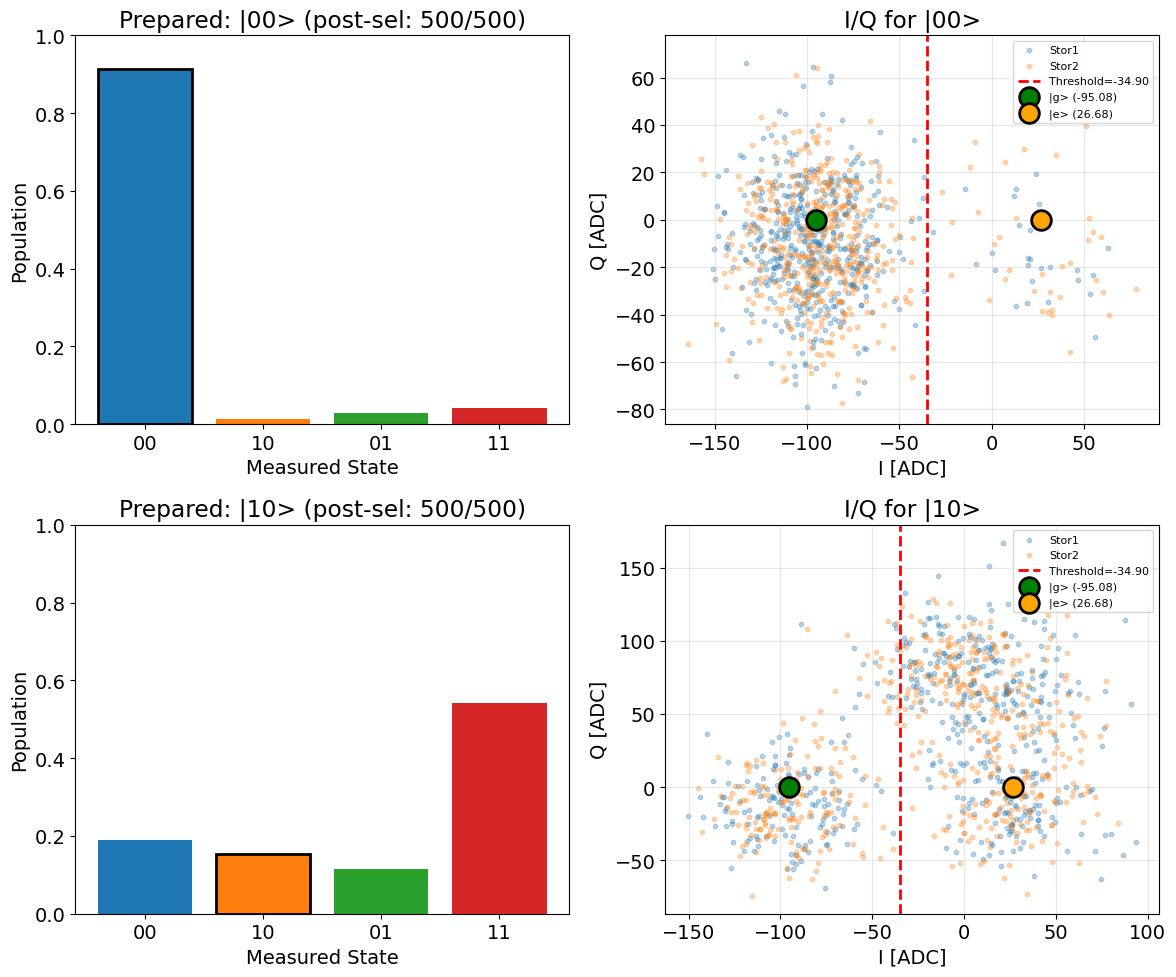

In [23]:
# 4. Execute - Basic state preparation test (no joint parity)
dual_rail_expt = dual_rail_sandbox_runner.execute(
    state_start=['00', '10'],  # Logical states
    storage_1=1,
    storage_2=3,
    wait_time=0,
    parity_flag=False,
    reps=500,
    go_kwargs=dict(analyze=False, display=False),
    active_reset=False,
)

# If using queue, analyze and display manually
if USE_QUEUE:
    dual_rail_expt.analyze(post_select=False)
    dual_rail_expt.display(show_iq=True)


# # 5. Execute with joint parity monitoring
# dual_rail_parity_expt = dual_rail_sandbox_runner.execute(
#     state_start=['10', '01'],  # Logical states
#     storage_1=1,
#     storage_2=3,
#     wait_time=10,              # 10 us wait between joint parity checks
#     repeat_count=5,            # Check parity 5 times
#     parity_flag=True,          # Enable joint parity measurement
#     parity_fast=False,
#     reps=200,
#     go_kwargs=dict(analyze=False, display=False),
# )

# if USE_QUEUE:
#     dual_rail_parity_expt.analyze(post_select=True)  # Post-select on 10/01 subspace
#     dual_rail_parity_expt.display(show_iq=True)
